In [1]:
import torch
import torchvision 
import torchvision.datasets as datasets
import torchvision.transforms as T
import numpy as np
from torch_geometric.data import InMemoryDataset, Data
from torch_geometric.loader import DataLoader

import matplotlib.pyplot as plt

from skimage.segmentation import slic
import skimage as ski

from multiprocessing import Pool

from sklearn.metrics import f1_score, accuracy_score

In [ ]:
# on collab: 
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

import torchvision 
import torchvision.datasets as datasets
import torchvision.transforms as T
import numpy as np

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

from torch_geometric.data import InMemoryDataset, Data
from torch_geometric.loader import DataLoader
from torch_geometric.transforms import ToSLIC

In [59]:
import mnist_slic
import model

Example for visualization

In [2]:
ds = datasets.MNIST(root = "./data", train=False, download=True, transform=T.ToTensor())

In [48]:
n_segments = 10
compactness = 0.1

# features 
get_avg_color = True
get_std_deviation_color = True
get_centroid = True
get_std_deviation_centroid = True
get_num_pixels = False
get_avg_color_distance = True
get_std_dev_color_distance = True


In [55]:
# same as function used in SuperPixelGraphMNIST
img, y = ds[1]
_, dim0, dim1 = img.shape
img_np = img.view(dim0, dim1).numpy()
s = slic(img_np, n_segments, compactness, start_label=0)
g = ski.future.graph.rag_mean_color(img_np, s)
n = g.number_of_nodes()
s1 = np.zeros([n, 1])  # for mean color and std deviation
s2 = np.zeros([n, 1])  # for std deviation
pos1 = np.zeros([n, 2]) # for centroid
pos2 = np.zeros([n, 2]) # for centroid std deviation
num_pixels = np.zeros([n, 1])
for idx in range(dim0 * dim1):
        idx_i, idx_j = idx % dim0, int(idx / dim0)
        node = s[idx_i][idx_j] - 1
        s1[node][0]  += img_np[idx_i][idx_j]
        s2[node][0]  += pow(img_np[idx_i][idx_j], 2)
        pos1[node][0] += idx_i
        pos1[node][1] += idx_j
        pos2[node][0] += pow(idx_i, 2)
        pos2[node][1] += pow(idx_j, 2)
        num_pixels[node][0] += 1

In [57]:
# computing features
edge_index = torch.from_numpy(np.array(g.edges).T).to(torch.long)
x = []
s1 = s1/num_pixels
avg_color = s1
if get_avg_color:
    x.append(torch.from_numpy(avg_color.flatten()).to(torch.float))
s2 = s2/num_pixels
std_deviation = np.sqrt(s2 - s1*s1)
if get_std_deviation_color:
    x.append(torch.from_numpy(std_deviation.flatten()).to(torch.float))
pos1 = pos1/num_pixels
pos = torch.from_numpy(pos1).to(torch.float)
if get_centroid:
    x.append(pos[:,0])
    x.append(pos[:,1])
if get_std_deviation_centroid:
    pos2 = pos2/num_pixels
    std_deviation_centroid = torch.from_numpy(np.abs(np.sqrt(pos2 - pos1*pos1))).to(torch.float)
    x.append(std_deviation_centroid[:,0])
    x.append(std_deviation_centroid[:,1])
if get_num_pixels:
    x.append(torch.from_numpy(num_pixels.flatten()).to(torch.float))
if get_avg_color_distance or get_std_dev_color_distance:
    distances = [[g.edges[u,v]['weight'] for u, v in g.edges(node_idx)] for node_idx in range(n)]
    if get_avg_color_distance:
        x.append(torch.Tensor([np.average(distance) for distance in distances]))
    if get_std_dev_color_distance:
        x.append(torch.Tensor([np.std(distance) for distance in distances]))
data = Data(x=torch.stack(x, dim=1), edge_index=edge_index, pos=pos, y=y)

In [35]:
import networkx as nx
from torch_geometric.utils import to_networkx

print(f'Grph with {g.number_of_nodes()} nodes and {g.number_of_edges()} edges')
print(f'Label: {data.y}')
color_feature = 0
pos = dict(zip(range(data.num_nodes), data.pos.numpy()))
nx.draw(g, pos=pos, node_color=data.x[:,color_feature])

Grph with 6 nodes and 10 edges


NameError: name 'data' is not defined

In [62]:
spds = mnist_slic.SuperPixelGraphMNIST(root='test-n75-c0.1-avg_color-std_deviation_color-centroid-std_deviation_centrtoid-avg_color_distance-std_deviation_color_distance')

Loaded.
Average number of nodes: 65.5877 with standard deviation 4.065305487906167
Average number of edges: 188.8811 with standard deviation 19.18797443165901


Grph with 60 nodes and 166 edges
Label: 0


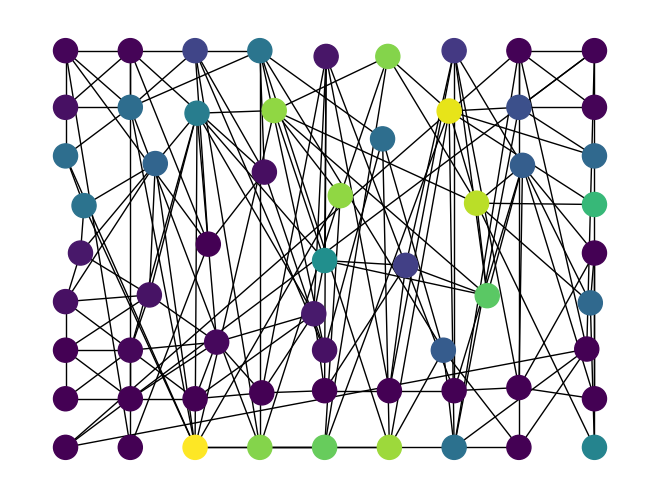

In [67]:
import networkx as nx
from torch_geometric.utils import to_networkx
data = spds[3]

g = to_networkx(data, to_undirected=True)
print(f'Grph with {g.number_of_nodes()} nodes and {g.number_of_edges()} edges')
print(f'Label: {data.y[0]}')
color_feature = 4
pos = dict(zip(range(data.num_nodes), data.pos.numpy()))
nx.draw(g, pos=pos, node_color=data.x[:,color_feature])
# acho que ta virado ?

In [64]:
data.num_node_features

6